In [1]:
import tensorflow as tf
from numpy import savez_compressed, load
from os import listdir
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy.random import random
from numpy import vstack
import numpy as np
from numpy.random import rand 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [2]:
def load_faces(directory, n_faces):
  model = MTCNN()
  faces = list()
  for file_name in listdir(directory):
    img = Image.open(directory + str("/")+ file_name)
    img = img.convert('RGB')
    pixels = np.asarray(img)
    face = get_face(model,pixels)
    if face is None :
      continue
    faces.append(face)
    if len(faces) >= n_faces:
      break
  return np.asarray(faces)

In [3]:
def plot_faces(faces,n_faces):
  for i in range(n_faces * n_faces):
    plt.subplot(n_faces,n_faces,i+1)
    plt.axis("off")
    plt.imshow(faces[i])
  plt.show()

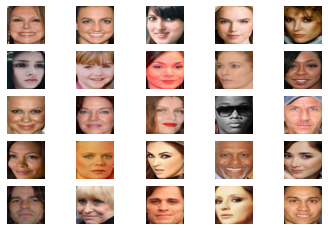

In [6]:
directory = "/content/drive/My Drive/img_align_celeba.zip (Unzipped Files)/img_align_celeba"
faces = load_faces(directory,500)
savez_compressed("celeb_faces_only.npz", faces)
plot_faces(faces,5)

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.6MB/s 


In [7]:
# Extracting only the faces from the celeb faces dataset
def get_face(model,pixels,output_size=(80,80)):
  faces = model.detect_faces(pixels)
  if len(faces) == 0 :
    return None
  x1,y1,width,height = faces[0]['box']
  x1,y1 = abs(x1), abs(y1)
  x2,y2 = x1 + width , y1 + height
  face_pixels = pixels[y1:y2,x1:x2]
  img = Image.fromarray(face_pixels)
  img = img.resize(output_size)
  face_array = np.asarray(img)
  return face_array

In [8]:
def discriminator_model(input_shape=(80,80,3)):
  model = Sequential()
  model.add(Conv2D(128,(5,5),padding="same",input_shape = input_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten()) 
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
  return model

In [9]:
def generator_model(latent_dim):
  model = Sequential()
  n_nodes = 128 * 5 * 5
  model.add(Dense(n_nodes,input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((5,5,128)))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3,(5,5),activation="tanh",padding="same"))
  return model

In [10]:
def gan_model(generator, discriminator):
  model = Sequential()
  discriminator.trainable = False
  model.add(generator)
  model.add(discriminator)
  optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy", optimizer=optimizer)
  return model

In [11]:
# Load and scale the real samples
def load_real_faces():
  face_data = load("celeb_faces_only.npz")
  faces = face_data["arr_0"]
  X = faces.astype("float32")
  X = (X-127.5) / 127.5
  return X

In [12]:
def select_real_samples(dataset, n_samples):
  idx = randint(0,dataset.shape[0],n_samples)
  X = dataset[idx]
  y = np.ones((n_samples,1))
  return X,y

In [13]:
def generate_latent_points(latent_dim, n_samples):
  inp = randn(latent_dim * n_samples)
  X = inp.reshape(n_samples,latent_dim)
  return X

In [14]:
def generate_fake_samples(generator,latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim,n_samples)
  x_output = generator.predict(x_input)
  y = np.zeros((n_samples,1))
  return x_output,y

In [21]:
def train_gan(generator, discriminator, gan_model,dataset, latent_dim,n_epochs=100,n_batches=10):
  batches_per_epoch = int(dataset.shape[0] / n_batches)
  half_batch = int(n_batches / 2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real,y_real = select_real_samples(dataset, half_batch)
      d_loss1, _ = discriminator.train_on_batch(x_real, y_real)
      x_fake,y_fake = generate_fake_samples(generator,latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim,n_batches)
      y_gan = np.ones((n_batches,1))
      g_loss = gan_model.train_on_batch(x_gan,y_gan)
      print("Epoch " + str(i) + " Batch " + str(j) + " Loss on real "+ str(d_loss1)+ " loss on fake " + str(d_loss2)+ " generator loss " + str(g_loss))
    if (i + 1) % 5 == 0 :
      summarize_model_performance(i, generator, discriminator, dataset, latent_dim)


In [22]:
def summarize_model_performance(i, generator, discriminator, dataset, latent_dim, n_samples=50):
  x_real, y_real = select_real_samples(dataset,n_samples)
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator,latent_dim, n_samples)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 0)
  print("Accuracy on real " + str(acc_real) + " Accuracy on fake " + str(acc_fake))
  x_fake = (x_fake + 1) / 2.0
  for k in range(5*5):
    plt.subplot(5,5,1+k)
    plt.axis("off")
    plt.imshow(x_fake[k])
  image_name = "generated_plot_e%03d.png" % (i+1)
  plt.savefig(image_name)
  plt.close()
  model_name = "generated_model_e%03d.h5" % (i+1)
  generator.save(model_name)

In [23]:
latent_dim = 100
discriminator = discriminator_model()
generator = generator_model(latent_dim)
gan = gan_model(generator, discriminator)
dataset = load_real_faces()
train_gan(generator, discriminator, gan,dataset, latent_dim,n_epochs=100,n_batches=10)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
Epoch 0 Batch 21 Loss on real 3.816013e-09 loss on fake 0.01773241 generator loss 34.99116
Epoch 0 Batch 22 Loss on real 1.6328297 loss on fake 3.2158782 generator loss 0.5001165
Epoch 0 Batch 23 Loss on real 8.1432773e-16 loss on fake 0.58800066 generator loss 2.3252525
Epoch 0 Batch 24 Loss on real 1.2626758e-10 loss on fake 0.68057865 generator loss 1.2632071
Epoch 0 Batch 25 Loss on real 7.688533e-10 loss on fake 0.74224865 generator loss 0.9663016
Epoch 0 Batch 26 Loss on real 1.35028895e-05 loss on fake 0.5508895 generator loss 1.2546289
Epoch 0 Batch 27 Loss on real 1.2421951e-05 loss on fake 0.30012164 generator loss 2.7085729
Epoch 0 Batch 28 Loss on real 0.018405491 loss on fake 0.04670178 generator loss 4.3904095
Epoch 0 Batch 29 Loss on real 6.1847923e-06 loss on fake 0.010327188 generator loss 5.3149834
Epoch 0 Batch 30 Loss on real 0.0021369427 loss on fake 0.00816842 generator loss 5.320315
Epoch 0 Batch 31 Loss on real 

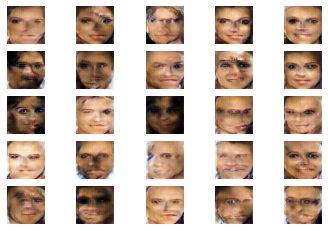

In [25]:
latent_points = generate_latent_points(100,30)
x = generator.predict(latent_points)
x = (x+1) / 2.0
for i in range(5*5):
  plt.subplot(5,5,i+1)
  plt.axis("off")
  plt.imshow(x[i,:,:])
plt.show()

